# VERSION 

**Transfromer Colab v1**

## Todos

- Save model
- check for other necessray callbacks
- run version 8 with 16 shift
- Embedding
    - evaluate embedding
    - run new embedding version on full asset data
    - search an try alternatives
        - add sin / cos signals
- Check for other LR scheduler
- Read for decoder necessety 

## Kernel

In [3]:
!pip install datatable
!pip install tensorflow-addons

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 



     |████████████████████████████████| 96.9 MB 118 kB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=7f668a9567a6bfffcefeb25d6c1512685587db7672af92f2c5ccab840ac4dea8
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 11.9 GB  | Proc size: 146.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [4]:
# Only if necessary to kill the session again

# !kill -9 -1


In [5]:
# %load_ext google.colab.data_table#To diable the display
# %unload_ext google.colab.data_table

In [7]:
import os
import gc
import datatable as dt
import traceback
import pdb
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML, Javascript

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow_addons.layers import MultiHeadAttention

import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from functools import partial
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Github/GResearch/
# if not os.path.exists("../input/g-research-crypto-forecasting/"): os.chdir('/t/Datasets/kaggle_crypto/internal')

Mounted at /content/gdrive
/content/gdrive/MyDrive/Github/GResearch


In [8]:
DEVICE = "GPU" #or "TPU"

SEED = 42

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# WHICH YEARS TO INCLUDE? YES=1 NO=0
INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

# TRAINING PARAMETERS
DEBUG = True
SINGLE_ASSET = True
asset_id=3
N_ASSETS = 14
num_shift = 15
TEMP_EMBEDDING = False
TIME2VEC_DIM=3
WINDOW_SIZE = 16
prediction_length = 1
BATCH_SIZE = 128
PCT_VALIDATION = 10 # last 10% of the data are used as validation set
PCT_TEST = 10 # last 10% of the data are used as validation set

In [9]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Num GPUs Available:  1


In [10]:
def compute_target(df):
    """
    
    """
    R=list()
    c=list(df['Close'])
    for i in range(df.shape[0]):
        future=c[min([i+16,df.shape[0]-1])]
        past=c[min([i+1,df.shape[0]-1])]
        R.append(future/past)
    df['R']=R
    df['R']=np.log(df['R'])
    df['pred']=np.exp(df['R'])-1
    return df


# we will use weighted correlation as function to evaluate our model performance
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def wmean(x, w):
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

def wcorr(x, y, w=1):
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))





def corr_loss(y_true, y_pred):
    x = tf.cast(y_true, tf.float32)
    y = tf.cast(y_pred, tf.float32)
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return - r

def combined_loss(y_true, y_pred, weight1=0.5, weight2=None):
    if not weight2:
        weight2 = 1 - weight1
    loss1 = corr_loss(y_true, y_pred)
    mae_loss_ = tf.keras.losses.MeanAbsoluteError()
    loss2 = mae_loss_(y_true, y_pred)
    return loss1*weight1 + loss2*weight2


def competition_weighted_correlation(a, b, weights=1):

    #w = np.ravel(weights)
    #a = np.ravel(a)
    #b = np.ravel(b)
    a = tf.cast(a, dtype=tf.float32)
    b = tf.cast(b, dtype=tf.float32)
    
    len_a = tf.cast(tf.size(a), dtype=tf.float32)
    len_b = tf.cast(tf.size(b), dtype=tf.float32)
    #sum_w = tf.reduce_sum(w)
    mean_a = tf.cast(tf.math.reduce_mean(a), dtype=tf.float32)
    mean_b = tf.cast(tf.math.reduce_mean(b), dtype=tf.float32)
    var_a = tf.cast(tf.math.reduce_sum(tf.math.square(a - mean_a)) / len_a, dtype=tf.float32)
    var_b = tf.cast(tf.math.reduce_sum(tf.math.square(b - mean_b)) / len_b, dtype=tf.float32)

    cov = tf.math.reduce_sum((a * b)) / len_a - (mean_a * mean_b)
    corr = cov / tf.math.sqrt(var_a * var_b)

    return corr

In [11]:
extra_data_files = {0: '', 
                    2: '', 
                    1: '', 
                    3: '', 
                    4: '', 
                    5: '', 
                    6: '', 
                    7: '', 
                    8: '', 
                    9: '', 
                    11:'', 
                    10:'', 
                    12:'', 
                    13:''}

# Uncomment to load the original csv [slower]
# orig_df_train = pd.read_csv(data_path + 'train.csv') 
# supp_df_train = pd.read_csv(data_path + 'supplemental_train.csv')
# df_asset_details = pd.read_csv(data_path  + 'asset_details.csv').sort_values("Asset_ID")

orig_df_train = dt.fread('orig_train.jay').to_pandas()
df_asset_details = dt.fread('orig_asset_details.jay').to_pandas()
supp_df_train = dt.fread('orig_supplemental_train.jay').to_pandas()
assets_details = dt.fread('orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

def load_training_data_for_asset(asset_id, load_jay = True):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    if load_jay:
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
    else: 
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [12]:
test = dt.fread('orig_example_test.jay').to_pandas()
sample_prediction_df = dt.fread('orig_example_sample_submission.jay').to_pandas()
assets = dt.fread('orig_asset_details.jay').to_pandas()
assets_order = dt.fread('orig_supplemental_train.jay').to_pandas().Asset_ID[:N_ASSETS]

assets_order = dict((t,i) for i,t in enumerate(assets_order))
print("Loaded all data!")

Loaded all data!


In [13]:
train = load_data_for_all_assets().sort_values('timestamp').set_index("timestamp")
if DEBUG: 
    train = train[-500000:]  # [-2221694:]  #
else:
    train = train[1000000:]
print(train.shape)

(500000, 10)


In [14]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [15]:


def get_time_features(df, row=False):  # TODO: can this be used as an alternative to temporal embeddings ?
    if not row:
        df = df.reset_index()
        timestamp = df["timestamp"].map(timestamp_to_date)
        df["sin_month"] = (np.sin(2 * np.pi * timestamp.dt.month/12))
        df["cos_month"] = (np.cos(2 * np.pi * timestamp.dt.month/12))
        df["sin_day"] = (np.sin(2 * np.pi * timestamp.dt.day/31))
        df["cos_day"] = (np.cos(2 * np.pi * timestamp.dt.day/31))
        df["sin_hour"] = (np.sin(2 * np.pi * timestamp.dt.hour/24))
        df["cos_hour"] = (np.cos(2 * np.pi * timestamp.dt.hour/24))
        df["sin_minute"] = (np.sin(2 * np.pi * timestamp.dt.minute/60))
        df["cos_minute"] = (np.cos(2 * np.pi * timestamp.dt.minute/60))
        df = df.set_index("timestamp")
    return df





def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# calculate z-score
def zscore(x, window):
    r = x.rolling(window=window, min_periods = 1)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z
def upper_shadow_15(df): return df['High'].rolling(window=15, min_periods=1).max() - np.maximum(df['Close'], df['Open']).shift(15)
def lower_shadow_15(df): return np.minimum(df['Close'], df['Open']).shift(15) - df['Low'].rolling(window=15, min_periods=1).min()


def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
    df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
    return df_feat


# A utility function to build features around lags.
def get_features_hist(df_feat, row=False):
    
    ### features to consider. See potential features...
    ### note that we predicting returns 15 minutes ahead. This minutes price data is therefore not sufficient. We must roll the variables, 15, 30, 90, 250, 1250
       
    # df_feat = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Count', 'VWAP', 'lr15', 'm', 'lr16', 'Asset_ID']].copy()

    if df_feat.shape[0]<3750:
        df_feat['beta_num'] = np.nan
        df_feat['m2'] = np.nan
    else:
        df_feat['beta_num'] = (df_feat['lr15']*df_feat['m']).rolling(3750).mean().values
        df_feat['m2'] = (df_feat['m']*df_feat['m']).rolling(3750).mean().values
        
    if row:
        # first .iloc as far back as we need, compute feature, then downsize until .iloc[-1]
        df_feat = df_feat.iloc[-1]
#         mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean()
#         med_price = df_feat[['Open', 'High', 'Low', 'Close']].median()
        df_feat['upper_shadow'] = df_feat['High'] / df_feat[['Close', 'Open']].max()
        df_feat['lower_shadow'] = df_feat[['Close', 'Open']].min() / df_feat['Low']
    else:
#         mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
#         med_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
        df_feat['upper_shadow'] = df_feat['High'] / df_feat[['Close', 'Open']].max(axis=1)
        df_feat['lower_shadow'] = df_feat[['Close', 'Open']].min(axis=1) / df_feat['Low']
        # df_feat = df_feat.drop('Asset_ID', axis=1)
        
    df_feat['beta'] = np.nan_to_num(df_feat['beta_num'] / df_feat['m2'], nan=0., posinf=0., neginf=0.)
    df_feat['target_lag'] = df_feat['lr15'] - df_feat['beta']*df_feat['m']  # first 15 entries of target_lagg are NaN

        ### Sense checks
#         print((df_feat['Target'] - df_feat.groupby('Asset_ID')['target_lag'].shift(-16)).abs().mean())
#         print(df_feat.loc[(df_feat.Target.isnull())&(df_feat.target_lag.notnull())].shape)
#         print(df_feat.loc[(df_feat.Target.notnull())&(df_feat.target_lag.isnull())].shape)        
        
    df_feat['open2close'] = df_feat['Close'] / df_feat['Open']
    df_feat['high2low'] = df_feat['High'] / df_feat['Low']
           
#     df_feat['high2mean'] = df_feat['High'] / mean_price
#     df_feat['low2mean'] = df_feat['Low'] / mean_price
#     df_feat['high2median'] = df_feat['High'] / med_price
#     df_feat['low2median'] = df_feat['Low'] / med_price
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    df_feat['close2vwap'] = df_feat['Close'] / df_feat['VWAP']
    

    # https://www.kaggle.com/rafalradwanski/g-research-features-to-increase-your-score
    df_feat['zscore_15_Close'] = zscore(df_feat['Close'], 15)
    df_feat['zscore_lower_shadow_15'] = zscore(lower_shadow_15(df_feat), 1440*30*12)
    df_feat['zscore_upper_shadow_15'] = zscore(upper_shadow_15(df_feat), 1440*30*12)
    df_feat['Return_15'] = (df_feat['Close'] / df_feat['Close'].shift(15)) - 1
    df_feat['Return_1h'] = (df_feat['Close'] / df_feat['Close'].shift(60)) - 1
    df_feat['Return_1d'] = (df_feat['Close'] / df_feat['Close'].shift(60*24)) - 1
    df_feat['Return_1w'] = (df_feat['Close'] / df_feat['Close'].shift(60*24*7)) - 1
    #df_feat['Candle_body_%'] = (df_feat['Close'] / df_feat['Open']) - 1
    df_feat['ATR_15'] = ((df_feat['High'].rolling(window=15, min_periods=1).max())/ (df_feat['Low'].rolling(window=15, min_periods=1).min()) - 1)
    df_feat['ATR_1h'] = ((df_feat['High'].rolling(window=60, min_periods=1).max())/ (df_feat['Low'].rolling(window=60, min_periods=1).min()) - 1)
    df_feat['ATR_1d'] = ((df_feat['High'].rolling(window=60*24, min_periods=1).max())/ (df_feat['Low'].rolling(window=60*24, min_periods=1).min()) - 1)
    df_feat['Z-score_return15_60'] = zscore(df_feat['Return_15'], 60)

    df_feat = df_feat.fillna(0)
    df_feat = df_feat.replace([np.inf, -np.inf], value=0)

    return df_feat

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def timestamp_to_date(timestamp):
    return(datetime.fromtimestamp(timestamp))

def get_lead_features():
    # get_features from ethereum
    pass



In [16]:
## FILTER DATAFRAME IF ONLY WORKING WITH ONE ASSET
if SINGLE_ASSET:
    train = train[train["Asset_ID"]==asset_id]
gc.collect()

50

In [17]:
train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']] = train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df

train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
print(train.shape)

# Matching records and marking generated rows as 'non-real'
print(train.shape)
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)
print(train.shape)

(35716, 10)
(35717, 10)
(35717, 10)
(35716, 12)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [18]:
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
# train = reduce_mem_usage(train)
gc.collect()

50

In [19]:
if train.index.name == "timestamp":
    train = train.reset_index()
train['lr15'] = train.groupby('Asset_ID')['Close'].apply(lambda x: log_return(x, 15))
train['lr16'] = train.groupby('Asset_ID')['Close'].apply(lambda x: log_return(x, 16))
train = train.merge(df_asset_details[['Asset_ID','Weight']], how='left', on = 'Asset_ID')
train['m'] = train['lr15']*train['Weight']
train['m'] = train.groupby('timestamp')['m'].transform('sum') / np.sum(df_asset_details['Weight'])

train.head(20)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date,group_num,is_real,asset_order,lr15,lr16,Weight,m
0,1621399380,3,13863.0,1.642700,1.649500,1.611000,1.623511,10208457.00,1.627059,0.006264,2021-05-19 04:43:00,0,1,0,NaN,NaN,4.406719,0.000000
1,1621399440,3,9173.0,1.623793,1.654195,1.615200,1.645859,6408643.00,1.640546,0.010261,2021-05-19 04:44:00,1,1,0,NaN,NaN,4.406719,0.000000
2,1621399500,3,9524.0,1.645627,1.673242,1.617400,1.664102,6283014.50,1.647340,0.016606,2021-05-19 04:45:00,2,1,0,NaN,NaN,4.406719,0.000000
3,1621399560,3,7761.0,1.663457,1.669406,1.631900,1.640231,4516063.00,1.650989,0.013718,2021-05-19 04:46:00,3,1,0,NaN,NaN,4.406719,0.000000
4,1621399620,3,6559.0,1.640461,1.664600,1.635679,1.658525,4456316.50,1.651940,0.021053,2021-05-19 04:47:00,4,1,0,NaN,NaN,4.406719,0.000000
5,1621399680,3,5590.0,1.658125,1.671800,1.643700,1.657311,3973633.75,1.655983,0.023950,2021-05-19 04:48:00,5,1,0,NaN,NaN,4.406719,0.000000
6,1621399740,3,8552.0,1.657763,1.660800,1.620500,1.639733,4245567.50,1.643210,0.021678,2021-05-19 04:49:00,6,1,0,NaN,NaN,4.406719,0.000000
7,1621399800,3,7144.0,1.640014,1.656900,1.628995,1.648322,3585431.25,1.644723,0.026200,2021-05-19 04:50:00,7,1,0,NaN,NaN,4.406719,0.000000
8,1621399860,3,8980.0,1.647378,1.649000,1.615000,1.628970,5622760.00,1.628477,0.027583,2021-05-19 04:51:00,8,1,0,NaN,NaN,4.406719,0.000000
9,1621399920,3,10643.0,1.630148,1.635000,1.600000,1.610441,7331379.50,1.614531,0.028171,2021-05-19 04:52:00,9,1,0,NaN,NaN,4.406719,0.000000


In [20]:
def get_split_indices(indices):
    train_end_idx = int(len(indices) * (1 - (PCT_VALIDATION+PCT_TEST)/100))
    val_end_idx = int(len(indices) * (1 - (PCT_TEST)/100))
    return indices[train_end_idx], indices[val_end_idx]

train_end_idx = {}
val_end_idx = {}
if not SINGLE_ASSET:
    for i in range(N_ASSETS):
        X_asset_indices = train[train["Asset_ID"]==i].index
        train_end_idx[i], val_end_idx[i] = get_split_indices(X_asset_indices)
else:
    X_asset_indices = train[train["Asset_ID"]==asset_id].index
    train_end_idx[asset_id], val_end_idx[asset_id] = get_split_indices(X_asset_indices)

In [21]:
# create train data of shape: Batch Size X Window Size X Num Assets --> bBATCH_SIZEon mean over all features
# create train lables of shape: batch size X Num Assets  -->  based on target of t(win_len)
# given data and index, train batches + labels are created


class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length, prediction_length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.prediction_length = prediction_length
        self.size = len(x_set)
    def __len__(self): return int((len(self.x)-self.length) / float(self.batch_size))
    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if (end_ind+self.prediction_length-1) <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1: end_ind+self.prediction_length-1]) 
        x,y = np.array(batch_x), np.array(batch_y)
        assert x.shape == (BATCH_SIZE, WINDOW_SIZE,len(features)), f"Shape Missmatch of train data generator X at idx {str(idx)} and i {str(i)}"
        assert x.shape == (BATCH_SIZE, WINDOW_SIZE,len(features)), f"Shape Missmatch of train data generator Y at idx {str(idx)} and i {str(i)}"
        return x,y

class multivariate_sample_generator(keras.utils.Sequence):
    # generator which supports multivariate ex-features input into nbeats
    # -> Single asset per sequence
    # --> x_sequence.shape = batch_size x Window_size x 1
    # --> y_sequence.shape = batch_size x 1
    # --> e_sequence.shape = batch_size x Window_size x num_ex_var    
    def __init__(self, x_set, y_set, e_set, batch_size, length, prediction_length):
        self.x, self.y, self.e = x_set, y_set, e_set
        self.batch_size = batch_size
        self.length = length
        self.prediction_length = prediction_length
        self.size = len(x_set)
        self.num_assets = self.x.shape[1]
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        # idx: how many times the generator is already called
        batch_x=[]
        batch_y=[]
        batch_e=[]
        num_sample=0
        while num_sample < self.batch_size:
            start_ind = self.batch_size//self.num_assets*idx + num_sample//self.num_assets
            end_ind = start_ind + self.length 
            if (end_ind+self.prediction_length-1) <= self.size:
                for a in range(self.num_assets):
                    batch_x.append(self.x[start_ind : end_ind, a])
                    batch_e.append(self.e[start_ind : end_ind, a, :])
                    batch_y.append(self.y[end_ind -1: end_ind+self.prediction_length-1, a]) 
                    num_sample += 1
                    if num_sample >= self.batch_size: break;  ## TODO: FIND BETTER SOLUTION (here we throw aray samples if we break out of loop)
        return [np.array(batch_x).reshape(-1,self.length,1), np.array(batch_e)], np.array(batch_y)
    

def assert_data_validity_generator(gen, batch_size, test_shift_size=1, num_tests=200):
    for i in range(num_tests):
        num_batch = np.random.randint(0, len(gen), dtype=int)
        num_sample = np.random.randint(0, batch_size-1, dtype=int)
        assert gen[num_batch][0][num_sample+test_shift_size,-1,0] == gen[num_batch][1][num_sample,0,0], "Data Missmatch between Series and Target in generator data"
    print("All tests passed.")


BATCH_SIZE:  128
Train batch shape: (128, 16, 1)
Target batch shape: (128, 1, 1)
Num batches of train, validation and test generator:  223 ,  27 ,  27
Num Training Samples:  28544


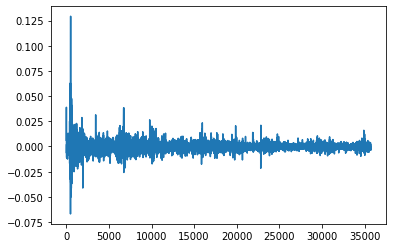

In [22]:
X_asset = train.copy()
X_asset = get_features_hist(X_asset)
X_asset["Target_shifted"] = X_asset["Target"].shift(num_shift)
X_asset["Target"].plot()

train_end_idx[asset_id], val_end_idx[asset_id]
features = ["Target_shifted"]
# features = ["Target_shifted", "m", "upper_shadow", "lower_shadow", "open2close", "high2low", "volume2count", "close2vwap"] 
target = ["Target"]
X_asset.loc[X_asset.is_real==0, features] = 0 
X_asset[features] = X_asset[features].fillna(0)
scaler = MinMaxScaler()
X_asset[features] = scaler.fit_transform(X_asset[features])  # TODO: NEEDS TO BE SEPARATED FOR TRAIN TEST
 
train_generator = sample_generator(X_asset.loc[:train_end_idx[asset_id], features], 
                                   X_asset.loc[:train_end_idx[asset_id], target], 
                                   length = WINDOW_SIZE, batch_size = BATCH_SIZE, prediction_length=prediction_length)
val_generator = sample_generator(X_asset.loc[train_end_idx[asset_id]:val_end_idx[asset_id], features], 
                                 X_asset.loc[train_end_idx[asset_id]:val_end_idx[asset_id], target], 
                                 length = WINDOW_SIZE, batch_size = BATCH_SIZE, prediction_length=prediction_length)
test_generator = sample_generator(X_asset.loc[val_end_idx[asset_id]:, features], 
                                  X_asset.loc[val_end_idx[asset_id]:, target], 
                                  length = WINDOW_SIZE, batch_size = BATCH_SIZE, prediction_length=prediction_length)

print("BATCH_SIZE: ", BATCH_SIZE)
print(f'Train batch shape: {train_generator[0][0].shape}')
print(f'Target batch shape: {train_generator[0][1].shape}')

print("Num batches of train, validation and test generator: ", len(train_generator),", ", len(val_generator),", ", len(test_generator))
print("Num Training Samples: ", len(train_generator)*BATCH_SIZE)

# <span class="title-section w3-xxlarge" id="training">Training 🏋️</span>
<hr>

Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variable `VERBOSE`. The variable `VERBOSE=1 or 2` will display the training and validation loss for each epoch as text. 

In [23]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):  # build automatically executed before layer is called for the first time --  mostly used to instantiate weights
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):  # where the layer logic lives
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))
    

# https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e
class T2V(keras.layers.Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):        
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)        
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)        
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)        
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)        
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [24]:
# https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.BatchNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        # self.ff_conv2 at build()
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.BatchNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)

        x = self.ff_norm(inputs + x)
        return x
    

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        if ff_dim is None:
            ff_dim = head_size
        self.dropout = dropout
        self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]

        
    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs)
        x = K.concatenate([inputs, time_embedding], -1)
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return K.reshape(x, (-1, x.shape[1] * x.shape[2])) # flat vector of features out
    

def build_model_new(
    input_shape,  # shape of time series sample
    head_size, # size of multi head attention
    num_heads,  # number of multi-head attention 
    ff_dim,  # 
    num_transformer_blocks, # 
    mlp_units, # list of N dense layers with i neurons
    dropout=0,  # transformer block dropout rate
    mlp_dropout=0,  # 
    time2vec_dim=3
):
    inputs = keras.Input(shape=input_shape)
    
    x = ModelTrunk(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, num_layers=num_transformer_blocks, time2vec_dim=time2vec_dim, dropout=dropout)(inputs)

    # x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, kernel_initializer="normal")(x)
    return keras.Model(inputs, outputs)


# https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/tf_positional_encodings.py
class TFPositionalEncoding1D(tf.keras.layers.Layer):
    def __init__(self, channels: int, dtype=tf.float32):
        """
        Args:
            channels int: The last dimension of the tensor you want to apply pos emb to.
        Keyword Args:
            dtype: output type of the encodings. Default is "tf.float32".
        """
        super(TFPositionalEncoding1D, self).__init__()

        self.channels = int(np.ceil(channels / 2) * 2)
        self.inv_freq = np.float32(
            1
            / np.power(
                10000, np.arange(0, self.channels, 2) / np.float32(self.channels)
            )
        )

    @tf.function
    def call(self, inputs):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(inputs.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")
        _, x, org_channels = inputs.shape

        dtype = self.inv_freq.dtype
        pos_x = tf.range(x, dtype=dtype)
        sin_inp_x = tf.einsum("i,j->ij", pos_x, self.inv_freq)
        emb = tf.expand_dims(tf.concat((tf.sin(sin_inp_x), tf.cos(sin_inp_x)), -1), 0)
        emb = emb[0]  # A bit of a hack
        return tf.repeat(emb[None, :, :org_channels], tf.shape(inputs)[0], axis=0)        
        

In [25]:
# https://keras.io/examples/timeseries/timeseries_transformer_classification/


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.BatchNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.BatchNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# self.time2vec = Time2Vec(kernel_size=time2vec_dim)

def build_model(
    input_shape,  # shape of time series sample
    head_size, # size of multi head attention
    num_heads,  # number of multi-head attention 
    ff_dim,  # 
    num_transformer_blocks, # 
    mlp_units, # list of N dense layers with i neurons
    dropout=0,  # transformer block dropout rate
    mlp_dropout=0,  # 
    temp_embedding=False
):
    inputs = keras.Input(shape=input_shape)
    
    if temp_embedding:
      time_embedding = TFPositionalEncoding1D(channels=input_shape[-1])(inputs)
      x = tf.keras.layers.Add()([inputs, time_embedding])
    else:
      x = inputs
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, kernel_initializer="normal")(x)
    return keras.Model(inputs, outputs)


In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [32]:
input_shape = train_generator[0][0].shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[128, 128],
    mlp_dropout=0.1,
    dropout=0.1,
    temp_embedding=TEMP_EMBEDDING
)

# tfp.stats.correlation
#tf_corr_new = tfp.stats.correlation(x, y=None, sample_axis=0, event_axis=-1, keepdims=False, name=None)
# tf.contrib.metrics.streaming_pearson_correlation(logits,labels)

# model.compile(
#     optimizer="Adam",
#     loss={"head1": "mse", "head2": "mse"},
#     loss_weights={"head1": HEAD1_WEIGHT, "head2": HEAD2_WEIGHT},
#     metrics={"head1": ["mae"], "head2": ["mae"]}
# )
# 
loss_func = combined_loss
model.compile(
    loss=loss_func,
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["mae", tfp.stats.correlation],
)
# model.summary()


In [33]:
model_filepath = f"/content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/"+ \
  f"tf_model_features_{len(features)}_seqlen_{WINDOW_SIZE}_tempembedding_{TEMP_EMBEDDING}"    # +"cp_{epoch:02d}"
history_filepath = f"/content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/history/"+ \
  f"tf_model_features_{len(features)}_seqlen_{WINDOW_SIZE}_tempembedding_{TEMP_EMBEDDING}.log"
  
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=10, restore_best_weights=True)]
callbacks += [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]
callbacks += [keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)]
callbacks += [keras.callbacks.CSVLogger(history_filepath, separator=',', append=False)]

EPOCHS = 20
history = model.fit(
            train_generator, 
            validation_data = (val_generator),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks)

model.evaluate(test_generator, verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/20
223/223 [==============================] - ETA: 0s - loss: 0.1036 - mae: 0.1107 - correlation: -0.0966
Epoch 1: val_loss improved from inf to -0.02465, saving model to /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


223/223 [==============================] - 56s 200ms/step - loss: 0.1036 - mae: 0.1107 - correlation: -0.0966 - val_loss: -0.0247 - val_mae: 0.0197 - val_correlation: 0.0690 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6.76e-05.
Epoch 2/20
223/223 [==============================] - ETA: 0s - loss: -0.0106 - mae: 0.0746 - correlation: 0.0959
Epoch 2: val_loss improved from -0.02465 to -0.08340, saving model to /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


223/223 [==============================] - 47s 211ms/step - loss: -0.0106 - mae: 0.0746 - correlation: 0.0959 - val_loss: -0.0834 - val_mae: 0.0294 - val_correlation: 0.1961 - lr: 6.7600e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.0001342.
Epoch 3/20
223/223 [==============================] - ETA: 0s - loss: -0.0457 - mae: 0.0668 - correlation: 0.1583
Epoch 3: val_loss improved from -0.08340 to -0.10749, saving model to /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


223/223 [==============================] - 57s 255ms/step - loss: -0.0457 - mae: 0.0668 - correlation: 0.1583 - val_loss: -0.1075 - val_mae: 0.0128 - val_correlation: 0.2278 - lr: 1.3420e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00020080000000000003.
Epoch 4/20
223/223 [==============================] - ETA: 0s - loss: -0.0569 - mae: 0.0555 - correlation: 0.1693
Epoch 4: val_loss did not improve from -0.10749
223/223 [==============================] - 27s 122ms/step - loss: -0.0569 - mae: 0.0555 - correlation: 0.1693 - val_loss: -0.1003 - val_mae: 0.0076 - val_correlation: 0.2081 - lr: 2.0080e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00026740000000000005.
Epoch 5/20
223/223 [==============================] - ETA: 0s - loss: -0.0583 - mae: 0.0511 - correlation: 0.1676
Epoch 5: val_loss did not improve from -0.10749
223/223 [==============================] - 27s 119ms/step - loss: -0.0583 - mae: 0.0511 - correlation: 0.1676 - val_loss: -0.0942 - 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


223/223 [==============================] - 45s 204ms/step - loss: -0.0619 - mae: 0.0441 - correlation: 0.1678 - val_loss: -0.1117 - val_mae: 0.0151 - val_correlation: 0.2385 - lr: 3.3400e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0004006000000000001.
Epoch 7/20
223/223 [==============================] - ETA: 0s - loss: -0.0655 - mae: 0.0397 - correlation: 0.1706
Epoch 7: val_loss improved from -0.11173 to -0.11550, saving model to /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Github/GResearch/G-ResearchCryptoPrediction/models/checkpoints/tf_model_features_1_seqlen_16_tempembedding_False/assets


223/223 [==============================] - 44s 199ms/step - loss: -0.0655 - mae: 0.0397 - correlation: 0.1706 - val_loss: -0.1155 - val_mae: 0.0055 - val_correlation: 0.2365 - lr: 4.0060e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004672000000000001.
Epoch 8/20
223/223 [==============================] - ETA: 0s - loss: -0.0748 - mae: 0.0313 - correlation: 0.1808
Epoch 8: val_loss did not improve from -0.11550
223/223 [==============================] - 27s 120ms/step - loss: -0.0748 - mae: 0.0313 - correlation: 0.1808 - val_loss: -0.1038 - val_mae: 0.0187 - val_correlation: 0.2263 - lr: 4.6720e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0005338000000000001.
Epoch 9/20
223/223 [==============================] - ETA: 0s - loss: -0.0595 - mae: 0.0221 - correlation: 0.1410
Epoch 9: val_loss did not improve from -0.11550
223/223 [==============================] - 27s 123ms/step - loss: -0.0595 - mae: 0.0221 - correlation: 0.1410 - val_loss: 0.0126 - val

[-0.11304162442684174, 0.0055184015072882175, 0.23160165548324585]

In [34]:
# tf.keras.utils.plot_model(get_model(), show_shapes=True)

In [ ]:
# load custom model from gdrive and compile
# model = keras.models.load_model(model_filepath, compile=False) # ,custom_objects={'loss_func':loss_func})
# model.compile(
#     loss=loss_func,
#     optimizer=keras.optimizers.Adam(learning_rate=1e-2),
#     metrics=["mae", tfp.stats.correlation],
# )

# history = pd.read_csv('training.log', sep=',', engine='python')

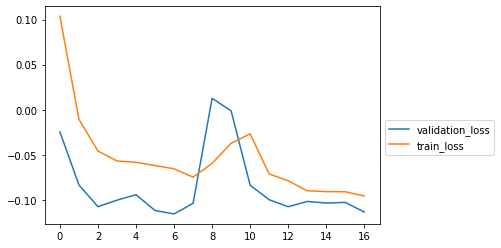

In [35]:
plt.plot(history.history['val_loss'], label= "validation_loss")
plt.plot(history.history['loss'], label= "train_loss")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
plt.show()

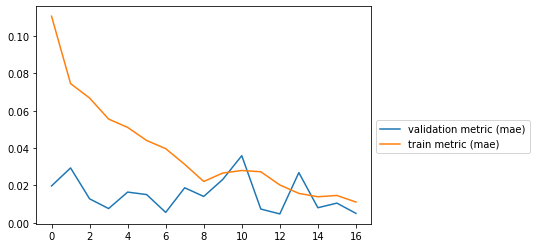

In [36]:
plt.plot(history.history['val_mae'], label= "validation metric (mae)")
plt.plot(history.history['mae'], label= "train metric (mae)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
plt.show()

In [37]:
history.history.keys()

dict_keys(['loss', 'mae', 'correlation', 'val_loss', 'val_mae', 'val_correlation', 'lr'])

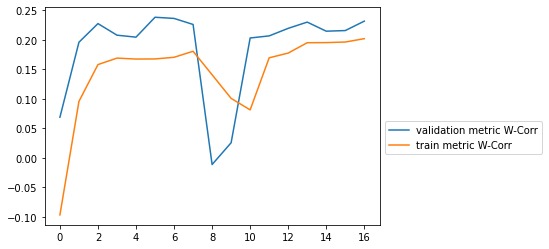

In [38]:
plt.plot(history.history['val_correlation'], label= "validation metric W-Corr")
plt.plot(history.history['correlation'], label= "train metric W-Corr")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
plt.show()

In [39]:
# create predictions on training set
predictions = model.predict(train_generator)
y_true = []
for x,y in train_generator: y_true.append(y)
y_true = np.squeeze(np.concatenate(y_true), axis=-1)


print(predictions.shape, y_true.shape)
assert predictions.shape == y_true.shape, f"{predictions.shape}, {y_true.shape}"

# Evaluate predictions on validation set
print("Window Size: ", WINDOW_SIZE)
print("Prediction length: ", prediction_length)
print("Epochs: ", EPOCHS)

print('---------------------')
print('Asset:    Corr. coef.')
print('---------------------')
asset_w_corr = []
asset_corrs = []
asset_mae = []
y_true = np.squeeze(y_true)
y_pred = np.squeeze(predictions)
real_target_ind = np.argwhere(y_true!=0)
# asset_id = list(assets_order.keys())[i]
# asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
mae_asset = mae(y_true, y_pred)
asset_corr = np.corrcoef(np.nan_to_num(y_pred.flatten()), np.nan_to_num(y_true.flatten()))[0,1]

print(f"corr: {asset_corr:.4f}")
print(f"mae: {mae_asset:.4f}")
print("\n")
print(f"Predictions Min: {predictions.min()}, Predictions Max: {predictions.max()}, Predictions mean:{predictions.mean()}, Predictions var:{predictions.var()}") 
print(f"y_true Min: {y_true.min()}, y_true Max: {y_true.max()}, y_true mean:{y_true.mean()}, y_true var:{y_true.var()}") 

(28544, 1) (28544, 1)
Window Size:  16
Prediction length:  1
Epochs:  20
---------------------
Asset:    Corr. coef.
---------------------
corr: 0.1021
mae: 0.0116


Predictions Min: -0.6278424859046936, Predictions Max: 0.09584435075521469, Predictions mean:-0.005062198266386986, Predictions var:0.0005257388111203909
y_true Min: -0.06692692637443542, y_true Max: 0.12924709916114807, y_true mean:9.636100730858743e-05, y_true var:2.547991789469961e-05


In [40]:
# create predictions on validation set
predictions = model.predict(val_generator)
y_true = []
for x,y in val_generator: y_true.append(y)
y_true = np.squeeze(np.concatenate(y_true), axis=-1)


print(predictions.shape, y_true.shape)
assert predictions.shape == y_true.shape, f"{predictions.shape}, {y_true.shape}"

# Evaluate predictions on validation set
print("Window Size: ", WINDOW_SIZE)
print("Prediction length: ", prediction_length)
print("Epochs: ", EPOCHS)

print('---------------------')
print('Asset:    Corr. coef.')
print('---------------------')
asset_w_corr = []
asset_corrs = []
asset_mae = []
y_true = np.squeeze(y_true)
y_pred = np.squeeze(predictions)
real_target_ind = np.argwhere(y_true!=0)
# asset_id = list(assets_order.keys())[i]
# asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
mae_asset = mae(y_true, y_pred)
asset_corr = np.corrcoef(np.nan_to_num(y_pred.flatten()), np.nan_to_num(y_true.flatten()))[0,1]

print(f"corr: {asset_corr:.4f}")
print(f"mae: {mae_asset:.4f}")
print("\n")
print(f"Predictions Min: {predictions.min()}, Predictions Max: {predictions.max()}, Predictions mean:{predictions.mean()}, Predictions var:{predictions.var()}") 
print(f"y_true Min: {y_true.min()}, y_true Max: {y_true.max()}, y_true mean:{y_true.mean()}, y_true var:{y_true.var()}") 

(3456, 1) (3456, 1)
Window Size:  16
Prediction length:  1
Epochs:  20
---------------------
Asset:    Corr. coef.
---------------------
corr: 0.1795
mae: 0.0055


Predictions Min: -0.05557682737708092, Predictions Max: 0.016026493161916733, Predictions mean:-0.0012807314051315188, Predictions var:6.316607323242351e-05
y_true Min: -0.00931723602116108, y_true Max: 0.010553549975156784, y_true mean:-0.00015768840967211872, y_true var:5.8620539675757755e-06


In [41]:
# create predictions on validation set
predictions = model.predict(test_generator)
y_true = []
for x,y in test_generator: y_true.append(y)
y_true = np.squeeze(np.concatenate(y_true), axis=-1)


print(predictions.shape, y_true.shape)
assert predictions.shape == y_true.shape, f"{predictions.shape}, {y_true.shape}"

# Evaluate predictions on validation set
print("Window Size: ", WINDOW_SIZE)
print("Prediction length: ", prediction_length)
print("Epochs: ", EPOCHS)

asset_w_corr = []
asset_corrs = []
asset_mae = []
y_true = np.squeeze(y_true)
predictions = np.squeeze(predictions)
real_target_ind = np.argwhere(y_true!=0)
# asset_id = list(assets_order.keys())[i]
# asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
mae_asset = mae(y_true, predictions)
asset_corr = np.corrcoef(np.nan_to_num(y_pred.flatten()), np.nan_to_num(y_true.flatten()))[0,1]

print('---------------------')
print('Asset:    Corr. coef.')
print('---------------------')
print(f"corr: {asset_corr:.4f}")
print(f"mae: {mae_asset:.4f}")
print("\n")
print(f"Predictions Min: {predictions.min()}, Predictions Max: {predictions.max()}, Predictions mean:{predictions.mean()}, Predictions var:{predictions.var()}") 
print(f"y_true Min: {y_true.min()}, y_true Max: {y_true.max()}, y_true mean:{y_true.mean()}, y_true var:{y_true.var()}") 



(3456, 1) (3456, 1)
Window Size:  16
Prediction length:  1
Epochs:  20
---------------------
Asset:    Corr. coef.
---------------------
corr: 0.0188
mae: 0.0055


Predictions Min: -0.08421896398067474, Predictions Max: 0.020707057788968086, Predictions mean:-0.0018745437264442444, Predictions var:7.9836965596769e-05
y_true Min: -0.009781436994671822, y_true Max: 0.016066623851656914, y_true mean:2.6940424504573457e-05, y_true var:5.281870926410193e-06
